In [1]:
import time
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("No GPU available. Using CPU.")




GPU is available. Using GPU.


In [3]:
import GPUtil
import psutil

# Get the GPU details
gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU: {gpu.name}, Driver: {gpu.driver}, Memory: {gpu.memoryTotal}MB")

# Get the RAM details
ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / (1024**3):.2f} GB")

GPU: NVIDIA GeForce RTX 4070 Laptop GPU, Driver: 556.12, Memory: 8188.0MB
Total RAM: 15.70 GB


In [4]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader, TensorDataset

data_directory = 'Sign Language for Alphabets'



In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
])

dataset = datasets.ImageFolder(root=data_directory, transform=transform)




In [30]:
total_images = len(dataset)
class_distribution = {dataset.classes[i]: sum([1 for _, label in dataset if label == i]) for i in range(len(dataset.classes))}

In [31]:
print(f'Total number of images: {total_images}')
print('Class distribution:')
for class_name, count in class_distribution.items():
    print(f'{class_name}: {count}')

Total number of images: 40500
Class distribution:
a: 1500
b: 1500
c: 1500
d: 1500
e: 1500
f: 1500
g: 1500
h: 1500
i: 1500
j: 1500
k: 1500
l: 1500
m: 1500
n: 1500
o: 1500
p: 1500
q: 1500
r: 1500
s: 1500
t: 1500
u: 1500
unknown: 1500
v: 1500
w: 1500
x: 1500
y: 1500
z: 1500


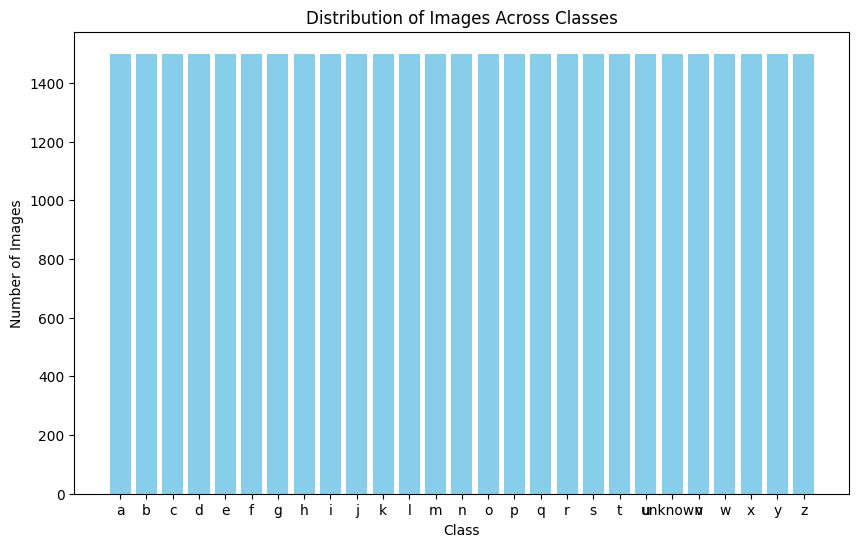

In [32]:
classes = list(class_distribution.keys())
counts = list(class_distribution.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
# plt.xticks(rotation=45)
plt.show()

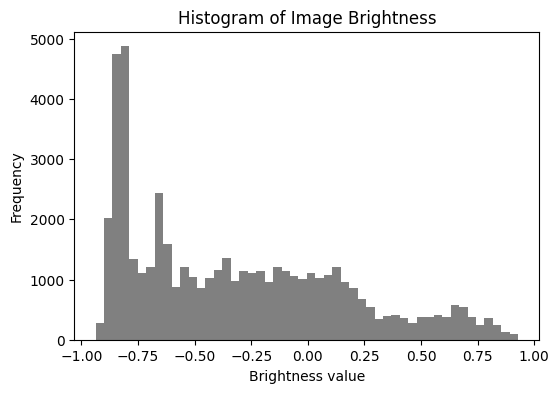

In [33]:
s_image = dataset[0][0].mean(0)
brightness_values = s_image.flatten()

plt.figure(figsize=(6, 4))
plt.hist(brightness_values, bins=50, color='gray')
plt.title('Histogram of Image Brightness')
plt.xlabel('Brightness value')
plt.ylabel('Frequency')
plt.show()


In [6]:
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
validation_size = len(dataset) - (train_size + test_size)

In [7]:
print(len(dataset))

39622


In [8]:
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


images.shape: torch.Size([32, 3, 224, 224])
tensor([15, 14,  8,  4, 11, 20, 10,  5,  9, 14, 15,  8, 12,  3, 15, 23, 12,  0,
         3, 14, 23,  3,  0, 22,  8, 26,  4,  6,  5,  5,  0, 19])


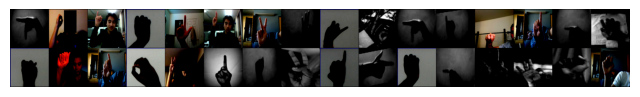

In [9]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    print(labels)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [10]:
import torch.nn as nn

class VGG13(nn.Module):
    def __init__(self, num_classes=27):  
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3,  stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3,  stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes), 
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x


model = VGG13()


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
model.to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [17]:
import time

start_time = time.time()
num_epochs = 50
val_accuracies = []
train_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted_train == targets).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2%}, Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2%}')

end_time = time.time()
time_to_train = end_time - start_time
print(f"Time to train: {time_to_train:.2f} seconds")

Epoch [1/50], Train Loss: 0.0777, Train Accuracy: 98.32%, Validation Loss: 0.0538, Validation Accuracy: 98.74%
Epoch [2/50], Train Loss: 0.0800, Train Accuracy: 98.30%, Validation Loss: 0.0538, Validation Accuracy: 98.74%
Epoch [3/50], Train Loss: 0.0777, Train Accuracy: 98.37%, Validation Loss: 0.0539, Validation Accuracy: 98.74%
Epoch [4/50], Train Loss: 0.0759, Train Accuracy: 98.33%, Validation Loss: 0.0537, Validation Accuracy: 98.74%
Epoch [5/50], Train Loss: 0.0803, Train Accuracy: 98.32%, Validation Loss: 0.0537, Validation Accuracy: 98.74%
Epoch [6/50], Train Loss: 0.0744, Train Accuracy: 98.32%, Validation Loss: 0.0539, Validation Accuracy: 98.74%
Epoch [7/50], Train Loss: 0.0779, Train Accuracy: 98.33%, Validation Loss: 0.0537, Validation Accuracy: 98.74%
Epoch [8/50], Train Loss: 0.0774, Train Accuracy: 98.32%, Validation Loss: 0.0537, Validation Accuracy: 98.74%
Epoch [9/50], Train Loss: 0.0755, Train Accuracy: 98.32%, Validation Loss: 0.0541, Validation Accuracy: 98.74%
E

In [18]:
torch.save(model.state_dict(), 'base_1_3.h5')

In [19]:
model.eval() 
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        
        _, predicted = torch.max(outputs, 1) 
        all_predictions.append(predicted)
        all_labels.append(labels)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}')


Test Loss: 0.0417, Test Accuracy: 98.92%


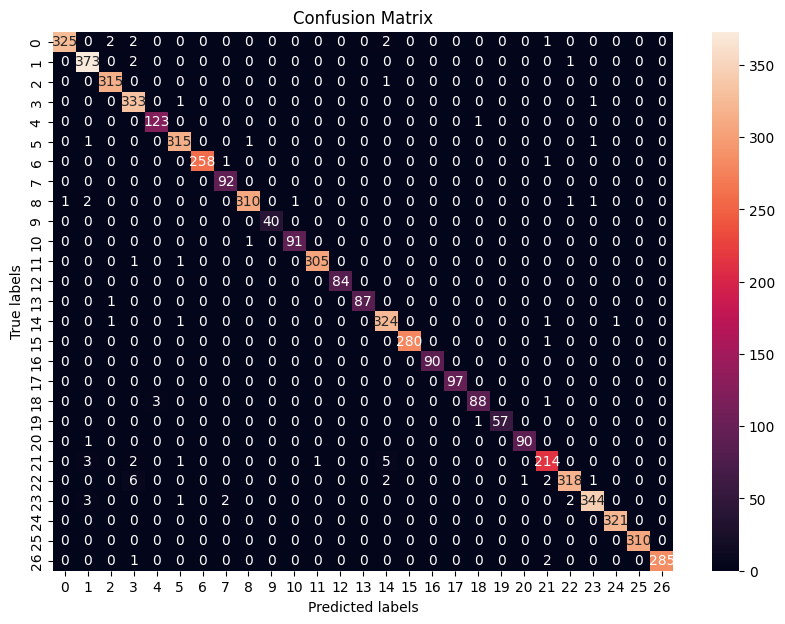

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

val_preds = []
val_targets = []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_preds.extend(predicted.cpu().numpy()) 
        val_targets.extend(labels.cpu().numpy()) 

cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


AlexNet


In [52]:
import torch
import torchvision.models as models

# Load a pretrained AlexNet model
model = models.alexnet(pretrained=False)

c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [53]:
import torch.nn as nn

model.classifier[6] = nn.Linear(4096, 27) 

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
model.to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [55]:
import time

start_time = time.time()
num_epochs = 3
val_accuracies = []
train_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted_train == targets).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2%}, Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2%}')

end_time = time.time()
time_to_train = end_time - start_time
print(f"Time to train: {time_to_train:.2f} seconds")

Epoch [1/3], Train Loss: 1.0487, Train Accuracy: 68.69%, Validation Loss: 0.3595, Validation Accuracy: 89.47%
Epoch [2/3], Train Loss: 0.3120, Train Accuracy: 90.50%, Validation Loss: 0.2157, Validation Accuracy: 93.91%
Epoch [3/3], Train Loss: 0.1784, Train Accuracy: 94.39%, Validation Loss: 0.1427, Validation Accuracy: 95.87%
Time to train: 233.97 seconds


In [49]:
torch.save(model.state_dict(), 'base_Alexnet.h5')

In [50]:
model.eval() 
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        
        _, predicted = torch.max(outputs, 1) 
        all_predictions.append(predicted)
        all_labels.append(labels)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}')


Test Loss: 0.1175, Test Accuracy: 97.04%


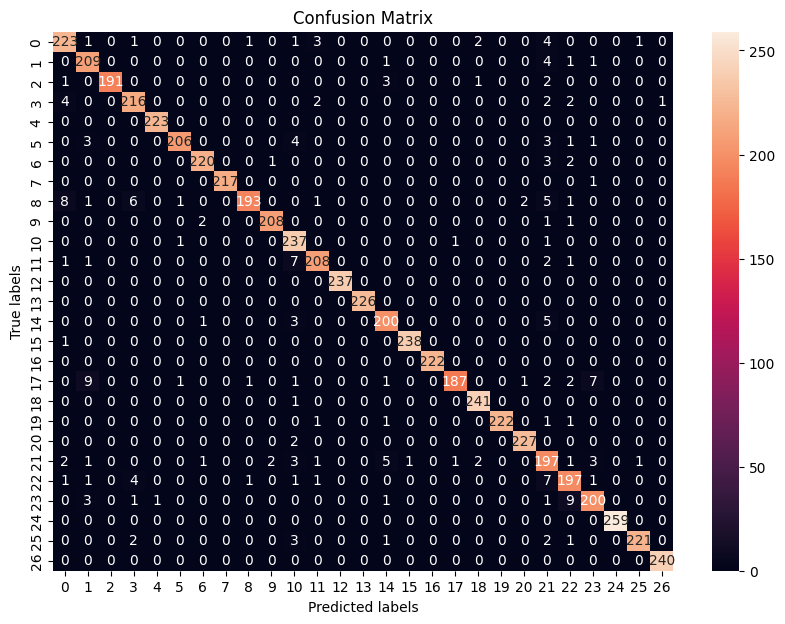

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

val_preds = []
val_targets = []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_preds.extend(predicted.cpu().numpy()) 
        val_targets.extend(labels.cpu().numpy()) 

cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


ConvNeXt


In [56]:
model = models.convnext_base(pretrained=False)

c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [58]:

num_classes = 27  # Change this to the number of classes in your dataset
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
model.to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
import time

start_time = time.time()
num_epochs = 3
val_accuracies = []
train_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted_train == targets).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2%}, Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2%}')

end_time = time.time()
time_to_train = end_time - start_time
print(f"Time to train: {time_to_train:.2f} seconds")

Epoch [1/3], Train Loss: 1.7171, Train Accuracy: 51.48%, Validation Loss: 0.9564, Validation Accuracy: 72.25%


In [ ]:
model = torch.load("model.pth", map_location=torch.device('cpu'))
model.eval()

In [14]:
model = torch.load("base_1_1.h5", map_location=torch.device('cpu'))
model.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [21]:
from PIL import Image
import torch
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


def preprocess_image(image_path):
    #image = Image.open(image_path).convert('RGB')  
    image = transform(image)
    image = image.unsqueeze(0)  
    return image


In [16]:
def classify_single_image(model, image_path, device):
    model.eval()  
    image = preprocess_image(image_path).to(device)  
    
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)  
    
    return predicted_class.item()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

predicted_class = classify_single_image(model, 'C:/Users/akhil/OneDrive/Desktop/dataset/Sign Language for Alphabets/a/a_25.jpg', device)
print(f"Predicted class: {predicted_class}")


AttributeError: 'collections.OrderedDict' object has no attribute 'to'

In [17]:
import torch

# Instantiate the model architecture
model = VGG13(num_classes=27)

# Load the state dictionary
model.load_state_dict(torch.load("base_1.h5", map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

# Now you can use model.eval() and proceed with classification


VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [23]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt



# Load the trained model and set to evaluation mode
model = VGG13(num_classes=27)
model.load_state_dict(torch.load("base_1_3.h5", map_location=torch.device('cpu')))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define transformations for each frame
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to preprocess frame and make predictions
def classify_frame(frame, model, device):
    # Convert the frame to a PIL image and apply transformations
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    image_tensor = transform(pil_image).unsqueeze(0).to(device)

    # Run the image through the model to get prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

# OpenCV video capture
cap = cv2.VideoCapture(0)  # Use 0 for default camera

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Classify the current frame
    predicted_class = classify_frame(frame, model, device)

    # Display prediction on the frame
    label = f"Class: {predicted_class}"
    cv2.putText(frame, label, (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Show the video feed
    cv2.imshow('Live Video Classification', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


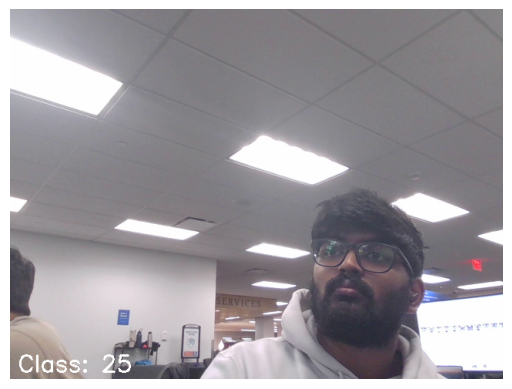

In [18]:
import matplotlib.pyplot as plt
import cv2

# Replace cv2.imshow with this function
def show_frame(frame):
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Display the frame
show_frame(frame)


In [ ]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Load the trained model and set to evaluation mode
model = VGG13(num_classes=27)
model.load_state_dict(torch.load("base_1.h5", map_location=torch.device('cpu')))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define transformations for each frameQ
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to preprocess frame and make predictions
def classify_frame(frame, model, device):
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Convert grayscale to 3 channels
    gray_frame_3ch = cv2.merge([gray_frame, gray_frame, gray_frame])
    
    # Convert the frame to a PIL image and apply transformations
    pil_image = Image.fromarray(gray_frame_3ch)
    image_tensor = transform(pil_image).unsqueeze(0).to(device)

    # Run the image through the model to get prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

# OpenCV video capture
cap = cv2.VideoCapture(0) 

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    predicted_class = classify_frame(frame, model, device)

    label = f"Class: {predicted_class}"
    cv2.putText(frame, label, (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    gray_display_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('Live Video Classification', cv2.merge([gray_display_frame, gray_display_frame, gray_display_frame]))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [61]:
import os

def rename_files(folder_path, new_name_base):
    # List all files in the given folder
    files = os.listdir(folder_path)
    
    # Loop through each file in the folder
    for index, file in enumerate(files):
        # Create the new file name using a base name and an index
        new_name = f"{new_name_base}_{index}{os.path.splitext(file)[1]}"
        
        # Create full file paths
        old_file_path = os.path.join(folder_path, file)
        new_file_path = os.path.join(folder_path, new_name)
        
        # Rename the file
        os.rename(old_file_path, new_file_path)
        print(f"Renamed {file} to {new_name}")

# Usage example
folder_path = "C:/Users/akhil/Downloads/archive (4)/American Sign Language (ASL)/data/Z"  # Change this to your folder's path
new_name_base = 'ZZ'        # Change this to the new base name you want for the files
rename_files(folder_path, new_name_base)


Renamed 0.jpg to ZZ_0.jpg
Renamed 1.jpg to ZZ_1.jpg
Renamed 10.jpg to ZZ_2.jpg
Renamed 100.jpg to ZZ_3.jpg
Renamed 101.jpg to ZZ_4.jpg
Renamed 102.jpg to ZZ_5.jpg
Renamed 103.jpg to ZZ_6.jpg
Renamed 104.jpg to ZZ_7.jpg
Renamed 105.jpg to ZZ_8.jpg
Renamed 106.jpg to ZZ_9.jpg
Renamed 107.jpg to ZZ_10.jpg
Renamed 108.jpg to ZZ_11.jpg
Renamed 109.jpg to ZZ_12.jpg
Renamed 11.jpg to ZZ_13.jpg
Renamed 110.jpg to ZZ_14.jpg
Renamed 111.jpg to ZZ_15.jpg
Renamed 112.jpg to ZZ_16.jpg
Renamed 113.jpg to ZZ_17.jpg
Renamed 114.jpg to ZZ_18.jpg
Renamed 115.jpg to ZZ_19.jpg
Renamed 116.jpg to ZZ_20.jpg
Renamed 117.jpg to ZZ_21.jpg
Renamed 118.jpg to ZZ_22.jpg
Renamed 119.jpg to ZZ_23.jpg
Renamed 12.jpg to ZZ_24.jpg
Renamed 120.jpg to ZZ_25.jpg
Renamed 121.jpg to ZZ_26.jpg
Renamed 122.jpg to ZZ_27.jpg
Renamed 123.jpg to ZZ_28.jpg
Renamed 124.jpg to ZZ_29.jpg
Renamed 125.jpg to ZZ_30.jpg
Renamed 126.jpg to ZZ_31.jpg
Renamed 127.jpg to ZZ_32.jpg
Renamed 128.jpg to ZZ_33.jpg
Renamed 129.jpg to ZZ_34.jpg
Re